# 引言

Backtrader是一个与Zipline类似的（本地化）量化策略回测框架。

安装直接在cmd上使用pip install backtrader即可。


这是对backtrader自动交易系统的介绍。我们将backtrader软件包分解为核心组件，并介绍创建自己交易系统的基本知识。

1、数据加载。交易策略的数据需要加载到回测框架中。

2、交易策略。交易策略是编程过程中最复杂的部分，因为这是决策买入/卖出标的部分。

3、回测框架设置。 Cerebro是回测器的名称。 Cerebro需要几个设置，例如（i）交易资本（ii）经纪佣金（iii）数据馈送（iv）交易策略（v）每个交易头寸的大小。

4、运行回测。运行Cerebro回测器并打印出所有已执行的交易。

5、评估性能。以图形方式评估回测交易策略的性能。

# 加载数据

In [15]:
#先引入后面可能用到的包（package）
import pandas as pd  
import numpy as np
import datetime
import backtrader as bt
import tushare as ts 
import matplotlib.pyplot as plt
%matplotlib inline   

In [16]:
#正常显示画图时出现的中文和负号
from pylab import mpl        
mpl.rcParams['figure.figsize'] = 13,8
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

## 交易策略

**交易策略类代码包含重要的参数和用于执行策略的功能。策略类的重要方面如下：**


params-这使您可以轻松更改交易策略中任何变量/参数的值，而不用深入代码本身。  
日志-这是您策略的日志记录功能。它将打印出该函数提供的日期时间和txt变量。  
init-这是用于初始化交易策略的类实例的代码。  
notify_order-跟踪任何订单的状态。订单具有提交，接受，购买/出售执行和价格，已取消/拒绝等状态。  
notify_trade-跟踪任何交易的状态。任何已平仓的交易都将报告毛利和净利润。  
下一个-这是实际制定交易策略的地方。下一个命令是指当我们进入下一个交易栏/窗口时，它执行检查以查看a。订单待处理吗？

In [17]:
import backtrader as bt
from datetime import datetime

class MyStrategy(bt.Strategy):
    params=(('short',30),                   # RSI的下限
            ('long',70),)                   # RSI的上限

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def next(self):
        if not self.position:
            if self.rsi < self.params.short:
                self.buy()
        else:
            if self.rsi > self.params.long:
                self.sell()

## 回测设置

回测器称为Cerebro，并且需要进行以下几种设置：

添加交易策略-必须将策略添加到回测器中，以便它可以开始测试系统的性能。
数据-数据需要添加到回测器，以便可以在其上实施交易策略。
经纪人设置-经纪人设置（例如，交易资本的金额和交易佣金）需要用来指示执行交易策略时积累的总财富和净财富。
头寸规模-设置作为策略一部分的交易规模。

In [18]:
from __future__ import (absolute_import, division, print_function,  
                        unicode_literals) 
from datetime import datetime
import tushare as ts
#以股票002537为例
df=ts.get_k_data('002537',start='2010-01-01')
df.index=pd.to_datetime(df.date)
#df['openinterest'] = 0
df=df[['open','high','low','close','volume']]
data = bt.feeds.PandasData(dataname=df,                               
                            fromdate=datetime(2013, 1, 1),                               
                            todate=datetime(2020, 4, 17) )
# 初始化cerebro回测系统设置                           
cerebro = bt.Cerebro()  
# 加载数据
cerebro.adddata(data) 
# 将交易策略加载到回测系统中
cerebro.addstrategy(MyStrategy) 
# 设置初始资本为10,000
cerebro.broker.setcash(100000.0) 
#每次固定交易数量
cerebro.addsizer(bt.sizers.FixedSize, stake=1000) 
#手续费
cerebro.broker.setcommission(commission=0.001) 

## 运行回测

这里重点是Analyzers模块的调用与结果输出，调用模块是cerebro.addanalyzer()，再从模块中获取分析指标，如夏普比率是bt.analyzers.SharpeRatio，然后是给该指标重命名方便之后调用，即 _name='SharpeRatio'。要获取分析指标，需要先执行回测系统，cerebro.run()，并将回测结果赋值给变量results，分析指标存储在results[0]里 (strat变量代替)，通过strat.analyzers.SharpeRatio.get_analysis()即可获取相应数据，其他指标操作方法类似。

In [19]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'SharpeRatio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')
results = cerebro.run()
strat = results[0]
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('SR:', strat.analyzers.SharpeRatio.get_analysis())
print('DW:', strat.analyzers.DW.get_analysis())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 110215.33
SR: OrderedDict([('sharperatio', 0.0940793146273168)])
DW: AutoOrderedDict([('len', 280), ('drawdown', 1.0118380107519704), ('moneydown', 1126.5999999999913), ('max', AutoOrderedDict([('len', 280), ('drawdown', 3.6074459027040535), ('moneydown', 4016.5999999999913)]))])


## 回测结果可视化

输出回测图表，一张大图上包含了三张图：  
（1）资金变动图：可以看到在实施交易策略的数据期内，资金的盈利/损失。  
（2）交易收益/亏损。蓝色（红色）点表示获利（亏损）交易以及获利（亏损）多少。  
（3）价格图表。绿色和红色箭头分别表示交易策略的进入点和退出点。黑线是交易标的随时间变化的价格， 条形图表示每个条形图期间资金的交易量。  


财富积累。 我们可以看到在实施交易策略的数据期内，财富的积累/损失。
交易收益/亏损。 蓝色（红色）点表示获利（亏损）交易以及获得（亏损）了多少。
价格图表。 绿色和红色箭头分别表示交易策略的进入点和退出点。 黑线是资产随时间的价格。 条形图表示每个条形图期间资产的交易量。

<IPython.core.display.Javascript object>


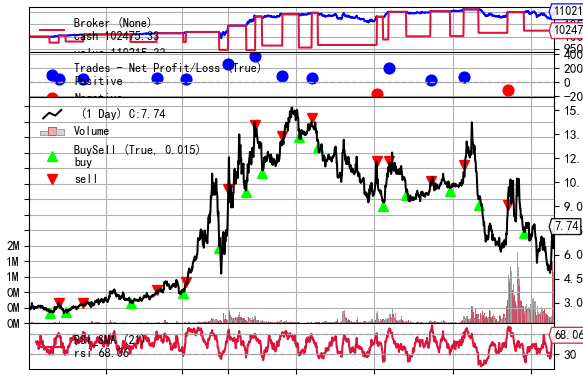

[[<Figure size 432x288 with 5 Axes>]]

In [20]:
%matplotlib inline 
cerebro.plot()

In [21]:
#cerebro.addanalyzer(bt.analyzers.TotalValue, _name='totalvalue')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annualreturn')
cerebro.addanalyzer(bt.analyzers.Calmar, _name='calmar')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.TimeDrawDown, _name='timedrawdown')
cerebro.addanalyzer(bt.analyzers.GrossLeverage, _name='grossleverage')
cerebro.addanalyzer(bt.analyzers.PositionsValue, _name='positionsvalue')
cerebro.addanalyzer(bt.analyzers.LogReturnsRolling, _name='logreturnsrolling')
cerebro.addanalyzer(bt.analyzers.PeriodStats, _name='periodstats')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharperatio')
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharperatio_A')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='tradeanalyzer')
cerebro.addanalyzer(bt.analyzers.Transactions, _name='transactions')
cerebro.addanalyzer(bt.analyzers.VWR, _name='vwr')

In [22]:
results = cerebro.run()
#Calmar比率
calmar=list(results[0].analyzers.calmar.get_analysis().values())[-1]
#平均回撤与最大回撤
drawdown_info=results[0].analyzers.drawdown.get_analysis()
average_drawdown_len=drawdown_info['len']
average_drawdown_rate=drawdown_info['drawdown']
average_drawdown_money=drawdown_info['moneydown']
max_drawdown_len=drawdown_info['max']['len']
max_drawdown_rate=drawdown_info['max']['drawdown']
max_drawdown_money=drawdown_info['max']['moneydown']
#期间统计指标
PeriodStats_info=results[0].analyzers.periodstats.get_analysis()
average_rate=PeriodStats_info['average']
stddev_rate=PeriodStats_info['stddev']
positive_year=PeriodStats_info['positive']
negative_year=PeriodStats_info['negative']
nochange_year=PeriodStats_info['nochange']
best_year=PeriodStats_info['best']
worst_year=PeriodStats_info['worst']
#SQN指标
SQN_info=results[0].analyzers.sqn.get_analysis()
sqn_ratio=SQN_info['sqn']
#VWR指标：波动率加权收益率
VWR_info=results[0].analyzers.vwr.get_analysis()
vwr_ratio=VWR_info['vwr']
#夏普比率
sharpe_info=results[0].analyzers.sharperatio.get_analysis()
# sharpe_info=results[0].analyzers._SharpeRatio_A.get_analysis()
sharpe_ratio=sharpe_info['sharperatio']

In [23]:
#将上述业绩评价指标放在同一个字典里
from collections import OrderedDict
performance=OrderedDict()
#字典赋值
#performance['calmar%']=round(calmar_ratio*100,4)
performance['average_drawdown_len']=round(average_drawdown_len)
performance['average_drawdown_rate']=round(average_drawdown_rate,2)
performance['average_drawdown_money']=round(average_drawdown_money,2)
performance['max_drawdown_len']=round(max_drawdown_len)
performance['max_drawdown_rate']=round(max_drawdown_rate,2)
performance['max_drawdown_money']=round(max_drawdown_money,2)
performance['average_rate%']=round(average_rate*100,2)
performance['stddev_rate%']=round(stddev_rate*100,2)
performance['positive_year']=round(positive_year)
performance['negative_year']=round(negative_year)
performance['nochange_year']=round(nochange_year)
performance['best_year%']=round(best_year*100,2)
performance['worst_year%']=round(worst_year*100,2)
performance['sqn_ratio']=round(sqn_ratio,2)
performance['vwr_ratio']=round(vwr_ratio,2)
performance['sharpe_info']=round(sharpe_ratio,2)
performance['omega']=0

In [24]:
#普通交易指标与多空交易指标
trade_1=OrderedDict()
trade_2=OrderedDict()
trade_info=results[0].analyzers.tradeanalyzer.get_analysis()
#普通交易指标的字典赋值   
trade_1['total_trade_num']=trade_info['total']['total']
trade_1['total_trade_opened']=trade_info['total']['open']
trade_1['total_trade_closed']=trade_info['total']['closed']
trade_1['total_trade_len']=trade_info['len']['total']
trade_1['long_trade_len']=trade_info['len']['long']['total']
trade_1['short_trade_len']=trade_info['len']['short']['total']
trade_1['longest_win_num']=trade_info['streak']['won']['longest']
trade_1['longest_lost_num']=trade_info['streak']['lost']['longest']
trade_1['net_total_pnl']=round(trade_info['pnl']['net']['total'],2)
trade_1['net_average_pnl']=round(trade_info['pnl']['net']['average'],2)
trade_1['win_num']=trade_info['won']['total']
trade_1['win_total_pnl']=round(trade_info['won']['pnl']['total'],2)
trade_1['win_average_pnl']=round(trade_info['won']['pnl']['average'],2)
trade_1['win_max_pnl']=round(trade_info['won']['pnl']['max'],2)
trade_1['lost_num']=trade_info['lost']['total']
trade_1['lost_total_pnl']=round(trade_info['lost']['pnl']['total'],2)
trade_1['lost_average_pnl']=round(trade_info['lost']['pnl']['average'],2)
trade_1['lost_max_pnl']=round(trade_info['lost']['pnl']['max'],2)

#多空交易指标字典赋值 
trade_2['long_num']=trade_info['long']['total']
trade_2['long_win_num']=trade_info['long']['won']
trade_2['long_lost_num']=trade_info['long']['lost']
trade_2['long_total_pnl']=round(trade_info['long']['pnl']['total'],2)
trade_2['long_average_pnl']=round(trade_info['long']['pnl']['average'],2)
trade_2['long_win_total_pnl']=round(trade_info['long']['pnl']['won']['total'],2)
trade_2['long_win_max_pnl']=round(trade_info['long']['pnl']['won']['max'],2)
trade_2['long_lost_total_pnl']=round(trade_info['long']['pnl']['lost']['total'],2)
trade_2['long_lost_max_pnl']=round(trade_info['long']['pnl']['lost']['max'],2)
trade_2['short_num']=trade_info['short']['total']
trade_2['short_win_num']=trade_info['short']['won']
trade_2['short_lost_num']=trade_info['short']['lost']
trade_2['short_total_pnl']=trade_info['short']['pnl']['total']
trade_2['short_average_pnl']=trade_info['short']['pnl']['average']
trade_2['short_win_total_pnl']=trade_info['short']['pnl']['won']['total']
trade_2['short_win_max_pnl']=trade_info['short']['pnl']['won']['max']
trade_2['short_lost_total_pnl']=trade_info['short']['pnl']['lost']['total']
trade_2['short_lost_max_pnl']=trade_info['short']['pnl']['lost']['max']

In [25]:
df=pd.DataFrame()
df['绩效指标名称']=performance.keys()
df['绩效指标值']=performance.values()
df['交易指标名称']=trade_1.keys()
df['交易指标值']=trade_1.values()
df['多空指标名称']=trade_2.keys()
df['多空指标值']=trade_2.values()

ValueError: Length of values does not match length of index

In [30]:
# 账户收益率
df0=df1=pd.DataFrame([results[0].analyzers.totalvalue.get_analysis()]).T
df0.columns=['total_value']
    
# 总的杠杆
df1=pd.DataFrame([results[0].analyzers.grossleverage.get_analysis()]).T
df1.columns=['GrossLeverage']
    

# 滚动的对数收益率
df2=pd.DataFrame([results[0].analyzers.logreturnsrolling.get_analysis()]).T
df2.columns=['log_return']
    
# year_rate
df3=pd.DataFrame([results[0].analyzers.annualreturn.get_analysis()]).T
df3.columns=['year_rate']
    
# 总的持仓价值
df4=pd.DataFrame(results[0].analyzers.positionsvalue.get_analysis()).T
df4['total_position_value']=df4.sum(axis=1)

AttributeError: 'ItemCollection' object has no attribute 'totalvalue'

In [28]:
def create_table(df, max_rows=18):
    """基于dataframe，设置表格格式"""
    
    table = html.Table(
        # Header
        [
            html.Tr(
                [
                    html.Th(col) for col in df.columns
                ]
            )
        ] +
        # Body
        [
            html.Tr(
                [
                    html.Td(
                        df.iloc[i][col]
                    ) for col in df.columns
                ]
            ) for i in range(min(len(df), max_rows))
        ]   
    )
    return table

In [20]:
import plotly.graph_objs as go
import dash
import dash_core_components as dcc                  # 交互式组件
import dash_html_components as html                 # 代码转html
from dash.dependencies import Input, Output         # 回调
from jupyter_plotly_dash import JupyterDash         # Jupyter中的Dash

app = JupyterDash('策略评估结果')
#server = app.server

colors = dict(background = 'white', text = 'black')

ModuleNotFoundError: No module named 'plotly'

In [29]:
strategy_name="RSI指标"

app.layout = html.Div(
        style = dict(backgroundColor = colors['background']),
        children = [
            html.H1(
                children='{}的策略评估结果'.format(strategy_name),
                style = dict(textAlign='center', color = colors['text'])),
            dcc.Graph(
                id='账户价值',
                figure = dict(
                    data = [{'x': list(df0.index), 'y': list(df0.total_value),
                             #'text':[int(i*1000)/10 for i in list(df3.year_rate)],
                             'type': 'scatter', 'name': '账户价值',
                            'textposition':"outside"}],
                    layout = dict(
                        title='账户价值',
                        plot_bgcolor = colors['background'], 
                        paper_bgcolor = colors['background'],
                        font = dict(color = colors['text'],
                       )
                    )
                )
            ),
            
            dcc.Graph(
                id='持仓市值',
                figure = dict(
                    data = [{'x': list(df4.index), 'y': list(df4.total_position_value),
                             #'text':[int(i*1000)/10 for i in list(df3.year_rate)],
                             'type': 'scatter', 'name': '持仓市值',
                            'textposition':"outside"}],
                    layout = dict(
                        title='持仓市值',
                        plot_bgcolor = colors['background'], 
                        paper_bgcolor = colors['background'],
                        font = dict(color = colors['text']),
                    )
                )
            ),
            dcc.Graph(
                id='年化收益',
                figure = dict(
                    data = [{'x': list(df3.index), 'y': list(df3.year_rate),
                             'text':[int(i*1000)/10 for i in list(df3.year_rate)],
                             'type': 'bar', 'name': '年收益率',
                            'textposition':"outside"}],
                    layout = dict(
                        title='年化收益率',
                        plot_bgcolor = colors['background'], 
                        paper_bgcolor = colors['background'],
                        font = dict(color = colors['text']),
                    )
                )
            ),
            create_table(df)        
            
        ]
    )

#app.run_server(debug=True, host='0.0.0.0')

NameError: name 'html' is not defined

In [239]:
app

安装
pip install dash  
pip install dash-daq     # Dash核心后端
上述安装时，会自动安装dash-renderer，dash-core-components，dash-html-components和dash-table；


配置Jupyter notebook
pip install jupyter_plotly_dash
安装成功后，如果在Jupyter notebook运行结果出现404错误，进行如下操作

conda install -c conda-forge jupyter-server-proxy

jupyter serverextension enable jupyter_server_proxy  # jupyter-server-proxy服务器扩展在安装时没有自动启用，这是一个依赖项jupyterlab-dash